In [540]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm import Cosmology
import scipy.integrate as integrate

In [541]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.3-0.045, Omega_b0=0.045, Omega_k0=0.0)

In [542]:
moo = clmm.Modeling(massdef='mean', delta_mdef=200, halo_profile_model='nfw')

moo.set_cosmo(cosmo)
moo.set_concentration(5)
moo.set_mass(1.e14)

z_cl = 0.1

In [543]:
def R_from_true(theta, R, Roff):
    return np.sqrt(R*R + Roff*Roff - 2*R*Roff*np.cos(theta))

def integrand1(theta, R, Roff):
    return moo.eval_surface_density(R_from_true(theta, R, Roff), z_cl)/(2*np.pi)

# Sigma exact
def Sigma_mis_exact(R, Roff):    
    return integrate.quad_vec(integrand1, 0., 2*np.pi, args=(R, Roff))[0]


# Sigma mean exact
def integrand_Sigmamean_exact(Rprime, Roff):    
    return Rprime * Sigma_mis_exact(Rprime, Roff)


In [544]:
import scipy
def Sigma_mean_mis_exact(R_arr, Roff):
    res=[]
    for i,R in enumerate(R_arr):
        res.append(integrate.quad(integrand_Sigmamean_exact, 0., R, args=(Roff))[0]*2./R/R)
    return np.array(res)

def Sigma_mean_mis_trap(R_arr, Roff, regrid=10):
    # use finer grid that R_arr to evaluate integral, for precision purpose. Controld by the regrid_level parameter. 
    # If regrid_level=1, the original R_arr is used for cumulative_trapezoid. 
    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), regrid)
    
    res = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * Sigma_mis_exact(new_R_arr, Roff), new_R_arr, initial=0)
    
    f = scipy.interpolate.interp1d(new_R_arr, res)
    return f(R_arr)


def DS_mis_approx(R_arr, Roff, regrid=1000): 
    return Sigma_mean_mis_trap(R_arr, Roff, regrid=regrid) - Sigma_mis_exact(R_arr, Roff)

def DS_mis_exact(R_arr, Roff): 
    return Sigma_mean_mis_exact(R_arr, Roff) - Sigma_mis_exact(R_arr, Roff)

In [545]:
Roff = 0.2
R_arr = np.logspace(-2,1,50)

In [546]:
Sigma_mis = Sigma_mis_exact(R_arr, Roff)

In [547]:
%%time 
DeltaSigma_mis_exact = DS_mis_exact(R_arr, Roff)

CPU times: user 2min 53s, sys: 394 ms, total: 2min 53s
Wall time: 2min 53s


In [548]:
%%time
DeltaSigma_mis_1e2 = DS_mis_approx(R_arr, Roff, regrid=100)

CPU times: user 132 ms, sys: 1.85 ms, total: 134 ms
Wall time: 136 ms


In [549]:
%%time 
DeltaSigma_mis_1e3 = DS_mis_approx(R_arr, Roff, regrid=1000)

CPU times: user 755 ms, sys: 4.52 ms, total: 759 ms
Wall time: 760 ms


In [550]:
%%time 
DeltaSigma_mis_1e4 = DS_mis_approx(R_arr, Roff, regrid=10000)

CPU times: user 7.75 s, sys: 20.6 ms, total: 7.77 s
Wall time: 7.77 s


In [551]:
Sigma = moo.eval_surface_density(R_arr, z_cl)
DeltaSigma = moo.eval_excess_surface_density(R_arr, z_cl)

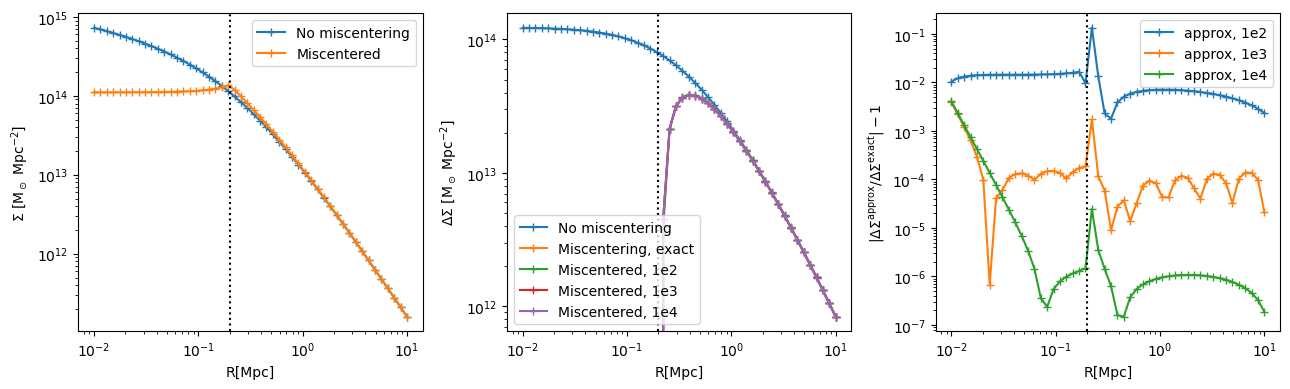

In [552]:
fig, axes = plt.subplots(ncols=3, figsize=(13,4))
axes[0].loglog(R_arr, Sigma, label='No miscentering', marker='+')
axes[0].loglog(R_arr, Sigma_mis, label='Miscentered', marker='+')
axes[0].axvline(Roff, c='k', ls=':')
axes[0].set_xlabel('R[Mpc]')
axes[0].set_ylabel(r'$\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[1].loglog(R_arr, DeltaSigma, label='No miscentering', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_exact, label='Miscentering, exact', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e2, label='Miscentered, 1e2', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e3, label='Miscentered, 1e3', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e4, label='Miscentered, 1e4', marker='+')
#axes[1].loglog(R_arr, DeltaSigma_mis_1e5, label='Miscentered, 1e5', marker='+')
axes[1].axvline(Roff, c='k', ls=':')
axes[1].legend()
axes[1].set_xlabel('R[Mpc]')
axes[1].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e2/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e2')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e3/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e3')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e4/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e4')
axes[2].axvline(Roff, c='k', ls=':')
axes[2].set_xlabel('R[Mpc]')
axes[2].set_ylabel(r'$|\Delta\Sigma^{\rm approx}/\Delta\Sigma^{\rm exact}|-1$')


axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()

In [725]:
Roff = 0.2

In [705]:
def Roff_distrib(Roff, Rmis=0.2):
    return np.exp(-Roff/Rmis) * Roff/(Rmis*Rmis)

def integrand_Sigmastack_mean_exact(Rprime, Roff): 
    return Rprime * Sigma_stack_mis_exact(Rprime, Roff)

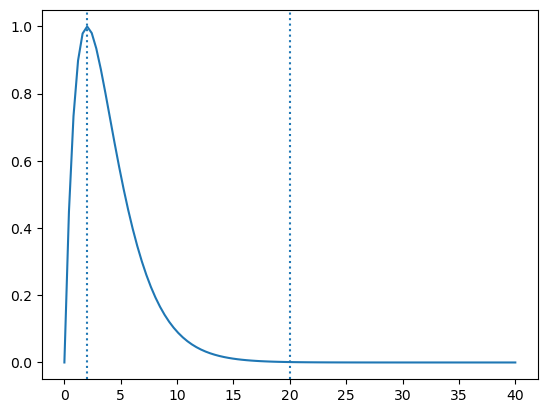

In [708]:
Roff_arr = np.linspace(0,20*Roff,100)
plt.plot(Roff_arr, Roff_distrib(Roff_arr, Rmis=Roff)/Roff_distrib(Roff, Rmis=Roff))
plt.axvline(Roff, linestyle=':')
plt.axvline(10.*Roff, linestyle=':')

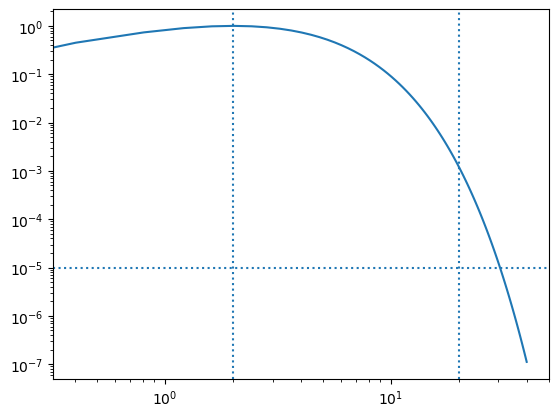

In [711]:
plt.loglog(Roff_arr, Roff_distrib(Roff_arr, Rmis=Roff)/Roff_distrib(Roff, Rmis=Roff))
plt.axvline(Roff, linestyle=':')
plt.axvline(10.*Roff, linestyle=':')
plt.axhline(1.e-5, linestyle=':')

In [572]:
R_arr_int = np.logspace(-5,4,100)

In [573]:
def Sigma_mis_interp(R, Roff):
    Sigma_mis = Sigma_mis_exact(R_arr_int, Roff)
    f_sigmamis = scipy.interpolate.interp1d(R_arr_int, Sigma_mis)
    return f_sigmamis(R)

In [686]:
def integrand_stack(Roff, R, Rmis):
    return Sigma_mis_interp(R, Roff) * Roff_distrib(Roff, Rmis)

def integrand_stack_tab(Roff_tab, R, Rmis):
    res = []
    for r in Roff_tab:
        res.append(Sigma_mis_interp(R, r) * Roff_distrib(r, Rmis))
    return np.array(res)

def Sigma_stack_mis_quad(R_arr, Rmis=3.):
    return integrate.quad_vec(integrand_stack, 1.e-5, 1.e5, args=(R, Rmis))[0]

def Sigma_stack_mis_simps(R_arr, Rmis, Rinfty_scale=10, ngrid=100):
    Roff_tab = np.linspace(0.,Rmis*Rinfty_scale,ngrid)
    tab = integrand_stack_tab(Roff_tab, R_arr, Rmis)
    return integrate.simpson(tab, Roff_tab, axis=0)

In [666]:
Sigma_mis_stack_simps = Sigma_stack_mis_simps(R_arr, Rmis=Roff)


In [684]:
def Sigma_mean_mis_stack_trap(R_arr, Rmis, ngrid=100, Rinfty_scale=10, ngrid_sigma=100):
    
    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), ngrid)
    res = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * Sigma_stack_mis_simps(new_R_arr, Rmis, Rinfty_scale=Rinfty_scale, ngrid=ngrid_sigma), new_R_arr, initial=0)
    
    f = scipy.interpolate.interp1d(new_R_arr, res)
    return f(R_arr)


In [727]:
Roff=0.2
R_arr2 = np.logspace(-2,np.log10(20),50)

Sigma = moo.eval_surface_density(R_arr2, z_cl)
Sigma_mis = Sigma_mis_exact(R_arr2, Roff)

In [728]:
DeltaSigma = moo.eval_excess_surface_density(R_arr2, z_cl)
DeltaSigma_mis = DS_mis_approx(R_arr2, Roff, regrid=1000)

In [729]:
Sigma_mis_stack = Sigma_stack_mis_simps(R_arr2, Rmis=Roff, Rinfty_scale=10, ngrid=1000)
Sigma_mean_stack_mis_trap = Sigma_mean_mis_stack_trap(R_arr2, Rmis=Roff, ngrid=1000, Rinfty_scale=10, ngrid_sigma=1000)
DeltaSigma_stack_mis = Sigma_mean_stack_mis_trap - Sigma_mis_stack

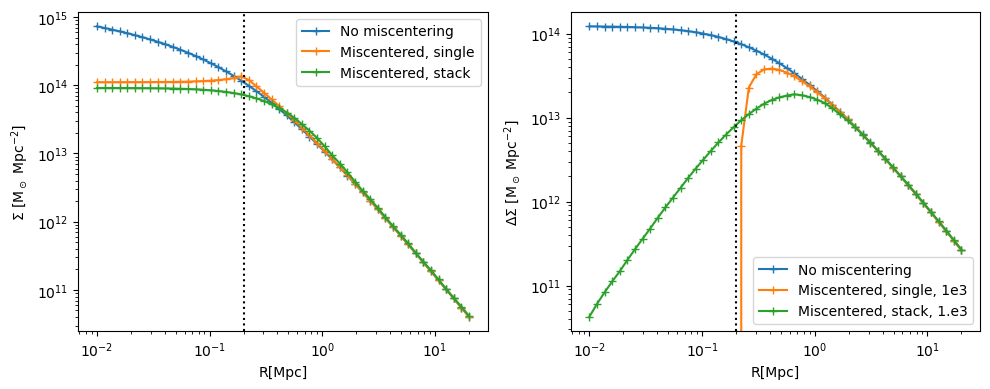

In [730]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].loglog(R_arr2, Sigma, label='No miscentering', marker='+')
axes[0].loglog(R_arr2, Sigma_mis, label='Miscentered, single', marker='+')
axes[0].loglog(R_arr2, Sigma_mis_stack, label='Miscentered, stack', marker='+')
axes[0].axvline(Roff, c='k', ls=':')
axes[0].set_xlabel('R[Mpc]')
axes[0].set_ylabel(r'$\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[1].loglog(R_arr2, DeltaSigma, label='No miscentering', marker='+')
axes[1].loglog(R_arr2, DeltaSigma_mis, label='Miscentered, single, 1e3', marker='+')
axes[1].loglog(R_arr2, DeltaSigma_stack_mis, label='Miscentered, stack, 1.e3', marker='+')
axes[1].axvline(Roff, c='k', ls=':')
axes[1].legend()
axes[1].set_xlabel('R[Mpc]')
axes[1].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[0].legend()
axes[1].legend()

fig.tight_layout()